In [1]:
import cptac
import cptac.utils as ut
import scipy
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy
import math
import pandas as pd

In [2]:
def Intersection(lst1, lst2): 
    return set(lst1).intersection(lst2)

In [3]:
def get_gene_list(dataframe):
    #Returns a list of the genes that are in both proteomics and transcriptomics
    gene_list = []
    prot = dataframe.get_proteomics()
    if isinstance(prot.columns, pd.MultiIndex):
        prot = prot.columns.get_level_values(0)
    trans = dataframe.get_transcriptomics()
    if isinstance(trans.columns, pd.MultiIndex):
        trans = trans.columns.get_level_values(0)
    for i in prot:
        if i in trans and i not in gene_list:
            gene_list.append(i)
    return gene_list

In [4]:
def correlation_list(tissue, gene_list, valid_sample_number = 30, tissue_type = "both"):
    #Returns a list of lists containing the name of the gene and the correlation
    corr_list = []
    pval_list = []
    prot = tissue.get_proteomics(tissue_type)
    if isinstance(prot.columns, pd.MultiIndex):
        prot = ut.reduce_multiindex(df = prot, levels_to_drop="Database_ID")
    
    trans = tissue.get_transcriptomics(tissue_type)
    if isinstance(trans.columns, pd.MultiIndex):
        trans = ut.reduce_multiindex(df = trans, levels_to_drop="Database_ID")
        
    prot_index_values = list(prot.index.values)
    trans_index_values = list(trans.index.values)
    

    for found_index in prot_index_values:
        if found_index not in trans_index_values:
            prot = prot.drop(index=found_index)
    for found_index in trans_index_values:
        if found_index not in prot_index_values:
            trans = trans.drop(index=found_index)
        
    for gene in gene_list:
        prot_measurements = prot[gene]
        prot_count = len(prot_measurements.dropna())
        
        trans_measurements = trans[gene]
        trans_count = len(trans_measurements.dropna())
        
        if prot_count < valid_sample_number or trans_count < valid_sample_number:
            continue
            
        nan_indices = set()
        prot_indices = list(prot_measurements.index.values)
        trans_indices = list(trans_measurements.index.values)
        
        #Here we are only currently taking the first column of multi_indices
        if isinstance(prot_measurements, pd.core.frame.DataFrame): 
            prot_measurements = prot_measurements.iloc[:,0]
        if isinstance(trans_measurements, pd.core.frame.DataFrame):
            trans_measurements = trans_measurements.iloc[:,0]
        for i in range(len(prot_measurements)):
            if math.isnan(prot_measurements[i]):
                nan_indices.add(prot_indices[i])
                
        for i in range(len(trans_measurements)):
            if math.isnan(trans_measurements[i]):
                nan_indices.add(trans_indices[i])
        
        nan_indices = list(nan_indices)
        prot_measurements = prot_measurements.drop(nan_indices)
        trans_measurements = trans_measurements.drop(nan_indices)
        
        correlation,pval = scipy.stats.pearsonr(prot_measurements, trans_measurements)
        if math.isnan(correlation):
            continue
        corr_list.append([gene,correlation])
        pval_list.append([gene, pval])
    return corr_list, pval_list

In [5]:
def ret_list(li):
    #Returns a list of correlations from all genes
    ret_li = []
    for i in li:
        ret_li.append(i[1])   
    return ret_li

In [6]:
def get_stage_corr(trans, prot, stage):
    #Stage is a list of patient numbers. This returns a correlation of those specific patients.
    stage_trans = {}
    for i in (trans):
        for j in dict(trans[i]).keys():
            if j in stage:
                if i not in stage_trans.keys():
                    stage_trans[i] = [trans[i].loc[j]]
                elif i in stage_trans.keys():
                    stage_trans[i].append(trans[i].loc[j])
    #             print(i+', '+j+': '+str(trans[i].loc[j]))
    stage_prot = {}
    for i in (prot):
        for j in dict(prot[i]).keys():
            if j in stage:
                if i not in stage_prot.keys():
                    stage_prot[i] = [prot[i].loc[j]]
                elif i in stage_prot.keys():
                    stage_prot[i].append(prot[i].loc[j])
    #             print(i+', '+j+': '+str(prot[i].loc[j]))
    prot_genes = stage_prot.keys()
    trans_genes = stage_trans.keys()
    stage_keys = sorted(Intersection(prot_genes, trans_genes))
    stage_correlations = []
    for gene in stage_keys:
        clean_prot = []
        clean_trans = []
        prot_list = stage_prot[gene]
        trans_list = stage_trans[gene]
        for index, val in enumerate(prot_list):
            if not math.isnan(prot_list[index]) and not math.isnan(trans_list[index]):
                clean_prot.append(prot_list[index])
                clean_trans.append(trans_list[index])
        if len(clean_trans) < 2 or len(clean_prot) < 2:
            continue
        corr, pval = scipy.stats.pearsonr(clean_prot,clean_trans)
        stage_correlations.append([gene, corr])
    return stage_correlations

In [7]:
cptac.download("brca")
cptac.download("ccrcc")
cptac.download("colon")
cptac.download("endometrial")
cptac.download("gbm")
cptac.download("luad")
cptac.download("ovarian")
cptac.download("hnscc")
cptac.download("lscc")

brca = cptac.Brca()
ccrcc = cptac.Ccrcc()
colon = cptac.Colon()
en = cptac.Endometrial()
gbm = cptac.Gbm()
luad = cptac.Luad()
ovarian = cptac.Ovarian()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 15)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 18)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 19)


In [8]:
brca_gene_list = get_gene_list(brca)
ccrcc_gene_list = get_gene_list(ccrcc)
colon_gene_list = get_gene_list(colon)
gbm_gene_list = get_gene_list(gbm)
luad_gene_list = get_gene_list(luad)
ovarian_gene_list = get_gene_list(ovarian)
en_gene_list = get_gene_list(en)
hnscc_gene_list = get_gene_list(hnscc)
lscc_gene_list = get_gene_list(lscc)

In [9]:
###NORMAL TISSUE
normal_brca_corr, normal_brca_pval = correlation_list(brca, brca_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_ccrcc_corr, normal_ccrcc_pval = correlation_list(ccrcc, ccrcc_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_colon_corr, normal_colon_pval = correlation_list(colon, colon_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_en_corr, normal_en_pval = correlation_list(en, en_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_gbm_corr, normal_gbm_pval = correlation_list(gbm, gbm_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_luad_corr, normal_luad_pval = correlation_list(luad,luad_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_ovarian_corr, normal_ovarian_pval = correlation_list(ovarian, ovarian_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_hnscc_corr, normal_hnscc_pval = correlation_list(hnscc, hnscc_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_lscc_corr, normal_lscc_pval = correlation_list(lscc, lscc_gene_list,valid_sample_number = 7, tissue_type="normal")

cptac warning: Due to dropping the specified levels, dataframe now has 655 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 7)
C:\Users\humbe\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 11)
cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 7)
cptac warning: Due to dropping the specified levels, dataframe now

LUAD STAGES TESTING

Sorting patients with different stages.
LUAD has no patients in the forth stage.

In [10]:
keys = []
for i in dict(luad.get_clinical()['Sample_Tumor_Normal']).keys():
    if dict(luad.get_clinical()['Sample_Tumor_Normal'])[i] == 'Tumor':
        keys.append(i)
first = []
second = []
third = []       
for i in keys:
    stage = (dict(luad.get_clinical()['Stage'])[i])
    if stage == '1A' or stage == '1B'or stage == '1':
        first.append(i)
    if stage == '2A' or stage == '2B':
        second.append(i)
    if stage == '3A' or stage == '3':
        third.append(i)

Getting proteomics and transcriptomics and making sure they are single leveled
For LUAD proteomics has a multiindex

In [11]:
prot = luad.get_proteomics('tumor')
trans = luad.get_transcriptomics('tumor')
prot = ut.reduce_multiindex(prot, levels_to_drop = 'Database_ID')

cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 3)


Getting correlations for the 3 available stages and getting list of results to plot

In [12]:
stage_1_corr = get_stage_corr(trans, prot, first)
stage_2_corr = get_stage_corr(trans, prot, second)
stage_3_corr = get_stage_corr(trans, prot, third)


stage_1 = ret_list(stage_1_corr)
stage_2 = ret_list(stage_2_corr)
stage_3 = ret_list(stage_3_corr)

Checking stages plots

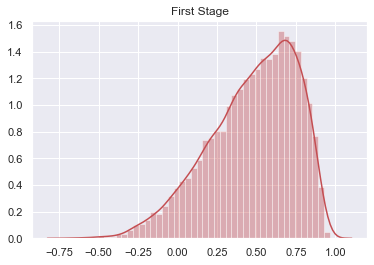

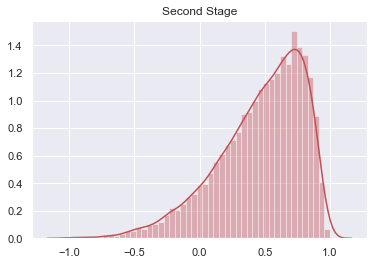

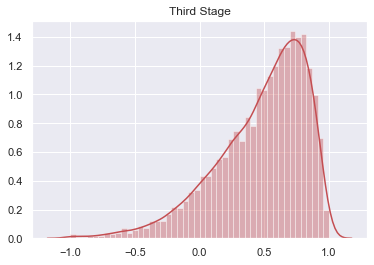

In [13]:
sns.distplot(stage_1 , color = "r").set_title('First Stage')
plt.show()
sns.distplot(stage_2 , color = "r").set_title('Second Stage')
plt.show()
sns.distplot(stage_3 , color = "r").set_title('Third Stage')
plt.show()


Getting list of healthy tissue to plot with stages.

In [14]:
normal_luad_corr_list = (ret_list(normal_luad_corr))

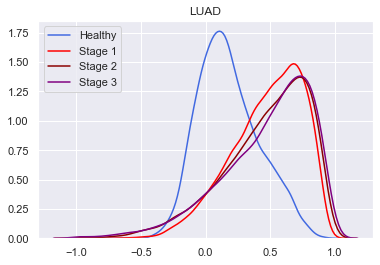

In [15]:
sns.kdeplot(normal_luad_corr_list, label="Healthy", color = "royalblue")
sns.kdeplot(stage_1, label="Stage 1", color = "red")
sns.kdeplot(stage_2, label="Stage 2", color = "darkred")
sns.kdeplot(stage_3, label="Stage 3", color = "purple").set_title('LUAD')
plt.show()

ENDOMETRIAL STAGES

Getting endometrial proteomics and transcriptomics

In [16]:
prot = en.get_proteomics('tumor')
trans = en.get_transcriptomics('tumor')

Sorting patient stages

In [17]:
en_stage_df = en.get_clinical()['FIGO_stage']

stage_1_names = []
stage_2_names = []
stage_3_names = []
stage_4_names = []

keys = dict(en_stage_df).keys()
for i in keys:
    if dict(en_stage_df)[i] == 'IA' or dict(en_stage_df)[i] == 'IB':
        stage_1_names.append(i)
    if dict(en_stage_df)[i] == 'II':
        stage_2_names.append(i)
    if dict(en_stage_df)[i] == 'IIIA' or dict(en_stage_df)[i] == 'IIIB' or dict(en_stage_df)[i] == 'IIIC2' or dict(en_stage_df)[i] == 'IIIC1':
        stage_3_names.append(i)
    if dict(en_stage_df)[i] == 'IVB':
        stage_4_names.append(i)

Getting correlations for different stages and returning a list to use plotting

In [18]:
stage_1_corr = get_stage_corr(trans, prot, stage_1_names)
stage_2_corr = get_stage_corr(trans, prot, stage_2_names)
stage_3_corr = get_stage_corr(trans, prot, stage_3_names)
stage_4_corr = get_stage_corr(trans, prot, stage_4_names)

stage_1 = ret_list(stage_1_corr)
stage_2 = ret_list(stage_2_corr)
stage_3 = ret_list(stage_3_corr)
stage_4 = ret_list(stage_4_corr)

C:\Users\humbe\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


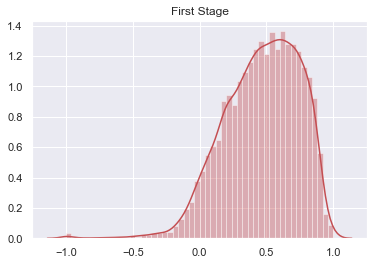

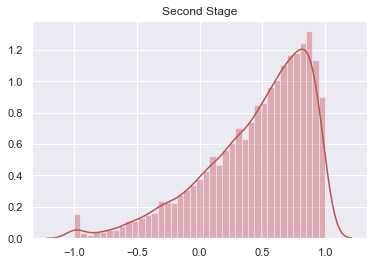

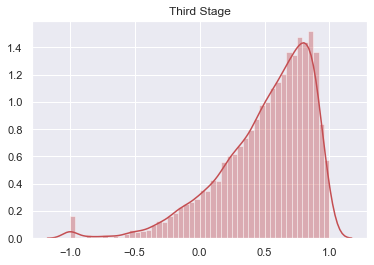

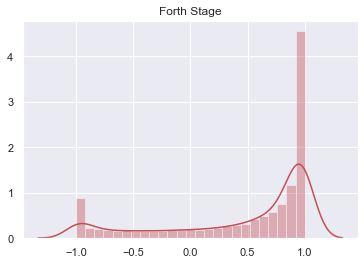

In [19]:
sns.distplot(stage_1 , color = "r").set_title('First Stage')
plt.show()
sns.distplot(stage_2 , color = "r").set_title('Second Stage')
plt.show()
sns.distplot(stage_3 , color = "r").set_title('Third Stage')
plt.show()
sns.distplot(stage_4 , color = "r").set_title('Forth Stage')
plt.show()

Getting a list with normal tissue to plot with stages

In [20]:

normal_en_corr_list = (ret_list(normal_en_corr)) 


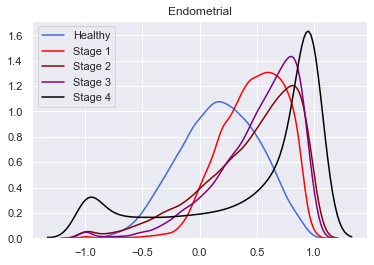

In [21]:
sns.kdeplot(normal_en_corr_list, label="Healthy", color = "royalblue")
sns.kdeplot(stage_1, label="Stage 1", color = "red")
sns.kdeplot(stage_2, label="Stage 2", color = "darkred")
sns.kdeplot(stage_3, label="Stage 3", color = "purple")
sns.kdeplot(stage_4, label="Stage 4", color = "black").set_title('Endometrial')
plt.show()

In [22]:
####CHECK DIFFERENCE IN ENDOMETRIAL

Different types of hystological types

In [23]:
hType = []
for i in en.get_clinical()['Histologic_type']:
    if i not in hType:
        hType.append(i)
hType

['Endometrioid', 'Serous', nan]

Finding patients in different stages with each type

In [24]:
# stage_1_names
stage_1_endo = []
stage_1_serous = []
histo = dict(en.get_clinical('tumor')['Histologic_type'])
for i in stage_1_names:
    if histo[i] == 'Endometrioid':
        stage_1_endo.append(i)
    if histo[i] == 'Serous':
        stage_1_serous.append(i)
        
        
# stage_2_names        
stage_2_endo = []
stage_2_serous = []

for i in stage_2_names:
    if histo[i] == 'Endometrioid':
        stage_2_endo.append(i)
    if histo[i] == 'Serous':
        stage_2_serous.append(i)

# stage_3_names        
stage_3_endo = []
stage_3_serous = []

for i in stage_3_names:
    if histo[i] == 'Endometrioid':
        stage_3_endo.append(i)
    if histo[i] == 'Serous':
        stage_3_serous.append(i)
        
# stage_4_names        
stage_4_endo = []
stage_4_serous = []

for i in stage_4_names:
    if histo[i] == 'Endometrioid':
        stage_4_endo.append(i)
    if histo[i] == 'Serous':
        stage_4_serous.append(i)

Getting correlations from each group

In [26]:
stage_1_endo_corr =  get_stage_corr(trans, prot, stage_1_endo)
stage_1_serous_corr =  get_stage_corr(trans, prot, stage_1_serous)
stage_2_endo_corr =  get_stage_corr(trans, prot, stage_2_endo)
stage_2_serous_corr =  get_stage_corr(trans, prot, stage_2_serous)
stage_3_endo_corr =  get_stage_corr(trans, prot, stage_3_endo)
stage_3_serous_corr =  get_stage_corr(trans, prot, stage_3_serous)
stage_4_endo_corr =  get_stage_corr(trans, prot, stage_4_endo)
stage_4_serous_corr =  get_stage_corr(trans, prot, stage_4_serous)

C:\Users\humbe\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Serous 2 and 4 do not exist

#Stage 1 and 3 only choices

Getting list to use for plotting

In [27]:
stage_1_e_c = ret_list(stage_1_endo_corr)
stage_1_s_c = ret_list(stage_1_serous_corr)

stage_3_e_c = ret_list(stage_3_endo_corr)
stage_3_s_c = ret_list(stage_3_serous_corr)


Plotting with normal tissue

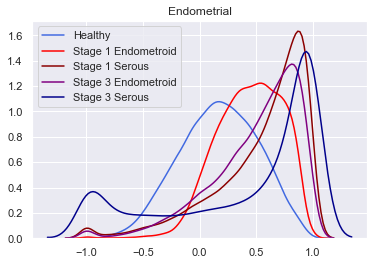

In [28]:
sns.kdeplot(normal_en_corr_list, label="Healthy", color = "royalblue")
sns.kdeplot(stage_1_e_c, label="Stage 1 Endometroid", color = "red")
sns.kdeplot(stage_1_s_c, label="Stage 1 Serous", color = "darkred")
sns.kdeplot(stage_3_e_c, label="Stage 3 Endometroid", color = "purple")
sns.kdeplot(stage_3_s_c, label="Stage 3 Serous", color = "darkblue").set_title('Endometrial')
plt.show()

HNSCC STAGES TESTING

Sorting patient stages

In [29]:
hnscc_stage_df = hnscc.get_clinical()['patho_staging_curated']
stage_1_names = []
stage_2_names = []
stage_3_names = []
stage_4_names = []

keys = dict(hnscc_stage_df).keys()
for i in keys:
    if dict(hnscc_stage_df)[i] == 'Stage I':
        stage_1_names.append(i)
    if dict(hnscc_stage_df)[i] == 'Stage II':
        stage_2_names.append(i)
    if dict(hnscc_stage_df)[i] == 'Stage III':
        stage_3_names.append(i)
    if dict(hnscc_stage_df)[i] == 'Stage IV':
        stage_4_names.append(i)

Getting HNSCC proteomic and transcriptomic data

In [30]:
prot = hnscc.get_proteomics('tumor')
trans = hnscc.get_transcriptomics('tumor')

Getting correlations for stages and lists to use in plots

In [31]:
stage_1_corr = get_stage_corr(trans, prot, stage_1_names)
stage_2_corr = get_stage_corr(trans, prot, stage_2_names)
stage_3_corr = get_stage_corr(trans, prot, stage_3_names)
stage_4_corr = get_stage_corr(trans, prot, stage_4_names)

stage_1 = ret_list(stage_1_corr)
stage_2 = ret_list(stage_2_corr)
stage_3 = ret_list(stage_3_corr)
stage_4 = ret_list(stage_4_corr)

C:\Users\humbe\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Plotting each stage

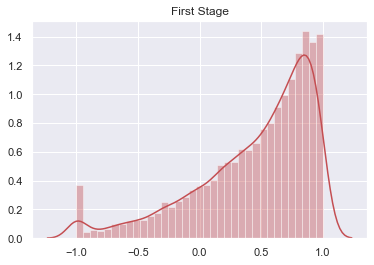

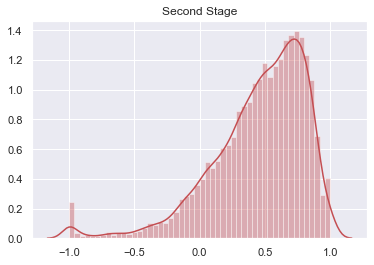

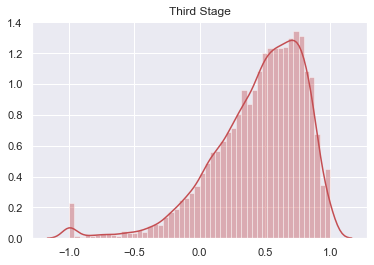

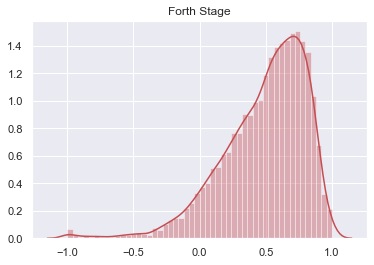

In [33]:
sns.distplot(stage_1 , color = "r").set_title('First Stage')
plt.show()
sns.distplot(stage_2 , color = "r").set_title('Second Stage')
plt.show()
sns.distplot(stage_3 , color = "r").set_title('Third Stage')
plt.show()
sns.distplot(stage_4 , color = "r").set_title('Forth Stage')
plt.show()

Plotting healthy and stages

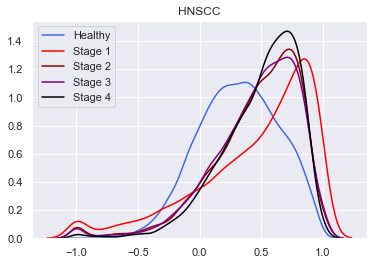

In [34]:
normal_hnscc_corr_list = (ret_list(normal_hnscc_corr)) 

sns.kdeplot(normal_hnscc_corr_list, label="Healthy", color = "royalblue")
sns.kdeplot(stage_1, label="Stage 1", color = "red")
sns.kdeplot(stage_2, label="Stage 2", color = "darkred")
sns.kdeplot(stage_3, label="Stage 3", color = "purple")
sns.kdeplot(stage_4, label="Stage 4", color = "black").set_title('HNSCC')
plt.show()

CCRCC STAGES

Sorting stages

In [35]:
unique = []
ccrcc_stage_df = ccrcc.get_clinical()['tumor_stage_pathological']
for i in ccrcc_stage_df:
    if i not in unique:
        unique.append(i)
stage_1_names = []
stage_2_names = []
stage_3_names = []
stage_4_names = []

keys = dict(ccrcc_stage_df).keys()
for i in keys:
    if dict(ccrcc_stage_df)[i] == 'Stage I':
        stage_1_names.append(i)
    if dict(ccrcc_stage_df)[i] == 'Stage II':
        stage_2_names.append(i)
    if dict(ccrcc_stage_df)[i] == 'Stage III':
        stage_3_names.append(i)
    if dict(ccrcc_stage_df)[i] == 'Stage IV':
        stage_4_names.append(i)


Getting CCRCC proteomics and transcriptomics

In [36]:
prot = ccrcc.get_proteomics('tumor')
prot = ut.reduce_multiindex(prot, levels_to_drop = 'Database_ID')
trans = ccrcc.get_transcriptomics('tumor')

cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 2)


Getting correlations and lists to use for plotting

In [37]:
stage_1_corr = get_stage_corr(trans, prot, stage_1_names)
stage_2_corr = get_stage_corr(trans, prot, stage_2_names)
stage_3_corr = get_stage_corr(trans, prot, stage_3_names)
stage_4_corr = get_stage_corr(trans, prot, stage_4_names)

stage_1 = ret_list(stage_1_corr)
stage_2 = ret_list(stage_2_corr)
stage_3 = ret_list(stage_3_corr)
stage_4 = ret_list(stage_4_corr)

C:\Users\humbe\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Plotting stages

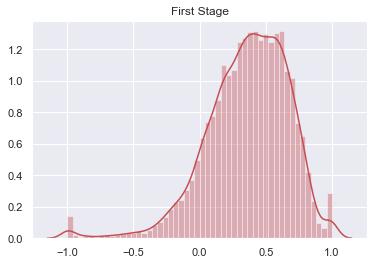

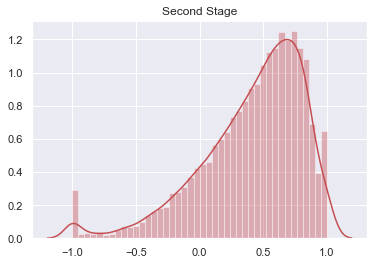

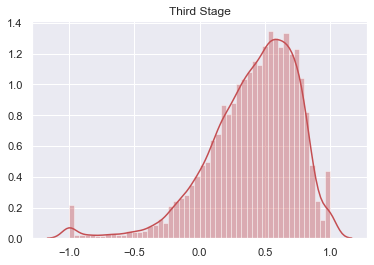

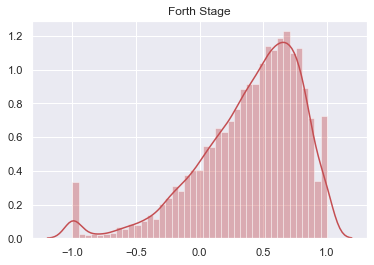

In [38]:
sns.distplot(stage_1 , color = "r").set_title('First Stage')
plt.show()
sns.distplot(stage_2 , color = "r").set_title('Second Stage')
plt.show()
sns.distplot(stage_3 , color = "r").set_title('Third Stage')
plt.show()
sns.distplot(stage_4 , color = "r").set_title('Forth Stage')
plt.show()

Plotting normal tissue with stages

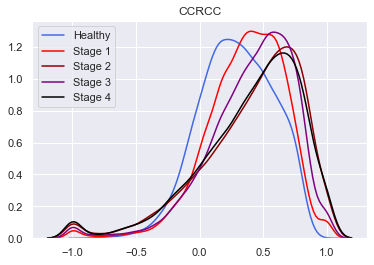

In [39]:
normal_ccrcc_corr_list = (ret_list(normal_ccrcc_corr)) 

sns.kdeplot(normal_ccrcc_corr_list, label="Healthy", color = "royalblue")
sns.kdeplot(stage_1, label="Stage 1", color = "red")
sns.kdeplot(stage_2, label="Stage 2", color = "darkred")
sns.kdeplot(stage_3, label="Stage 3", color = "purple")
sns.kdeplot(stage_4, label="Stage 4", color = "black").set_title('CCRCC')
plt.show()

LSCC STAGES

Sorting stages

In [40]:
unique = []
lscc_stage_df = lscc.get_clinical()['Stage']
for i in lscc_stage_df:
    if i not in unique:
        unique.append(i)
stage_1_names = []
stage_2_names = []
stage_3_names = []
stage_4_names = []

keys = dict(lscc_stage_df).keys()
for i in keys:
    if dict(lscc_stage_df)[i] == 'I' or dict(lscc_stage_df)[i] == 'IA' or dict(lscc_stage_df)[i] == 'IB':
        stage_1_names.append(i)
    if dict(lscc_stage_df)[i] == 'II' or  dict(lscc_stage_df)[i] == 'IIA' or dict(lscc_stage_df)[i] == 'IIB':
        stage_2_names.append(i)
    if dict(lscc_stage_df)[i] == 'III' or dict(lscc_stage_df)[i] == 'IIIA' or dict(lscc_stage_df)[i] == 'IIIB':
        stage_3_names.append(i)
    if dict(lscc_stage_df)[i] == 'IV':
        stage_4_names.append(i)


Getting LSCC proteomics and transcriptomics

In [41]:
prot = lscc.get_proteomics('tumor')
prot = ut.reduce_multiindex(prot, levels_to_drop = 'Database_ID')
trans = lscc.get_transcriptomics('tumor')

cptac warning: Due to dropping the specified levels, dataframe now has 858 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 2)


Getting correlations and lists to use for plotting

In [42]:
stage_1_corr = get_stage_corr(trans, prot, stage_1_names)
stage_2_corr = get_stage_corr(trans, prot, stage_2_names)
stage_3_corr = get_stage_corr(trans, prot, stage_3_names)
stage_4_corr = get_stage_corr(trans, prot, stage_4_names)

stage_1 = ret_list(stage_1_corr)
stage_2 = ret_list(stage_2_corr)
stage_3 = ret_list(stage_3_corr)
stage_4 = ret_list(stage_4_corr)

Plotting each stage

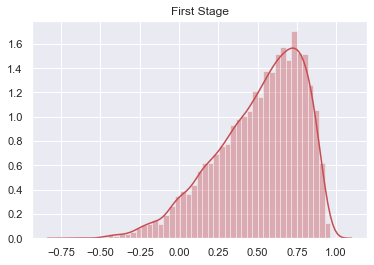

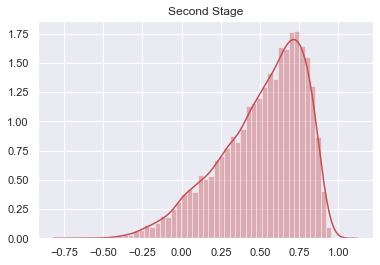

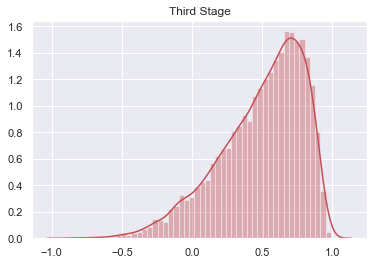

C:\Users\humbe\miniconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


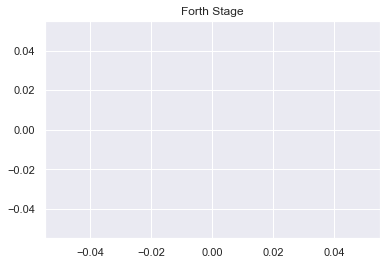

In [43]:
sns.distplot(stage_1 , color = "r").set_title('First Stage')
plt.show()
sns.distplot(stage_2 , color = "r").set_title('Second Stage')
plt.show()
sns.distplot(stage_3 , color = "r").set_title('Third Stage')
plt.show()
sns.distplot(stage_4 , color = "r").set_title('Forth Stage')
plt.show()

Getting normal tissue to compare with stages

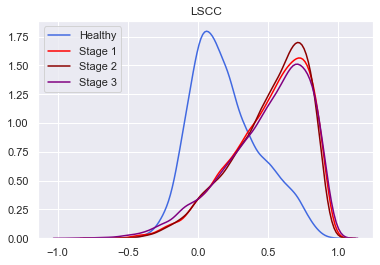

In [44]:
normal_lscc_corr_list = (ret_list(normal_lscc_corr)) 

sns.kdeplot(normal_lscc_corr_list, label="Healthy", color = "royalblue")
sns.kdeplot(stage_1, label="Stage 1", color = "red")
sns.kdeplot(stage_2, label="Stage 2", color = "darkred")
sns.kdeplot(stage_3, label="Stage 3", color = "purple")
sns.kdeplot(stage_4, label="Stage 4", color = "black").set_title('LSCC')
plt.show()

Text(0.5, 1.0, 'LSCC')

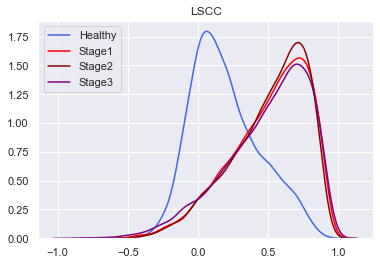

In [45]:
normal_lscc_corr_list = (ret_list(normal_lscc_corr)) 

sns.kdeplot(normal_lscc_corr_list, label="Healthy", color = "royalblue")
sns.kdeplot(stage_1, label="Stage1", color = "red")
sns.kdeplot(stage_2, label="Stage2", color = "darkred")
sns.kdeplot(stage_3, label="Stage3", color = "purple").set_title('LSCC')
# sns.kdeplot(stage_4, label="Stage4", color = "black")


GBM STAGES

GBM ONLY HAS STAGE 4

In [46]:
gbm_corr, gbm_pval = correlation_list(gbm, gbm_gene_list, tissue_type="tumor")


cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 11)
C:\Users\humbe\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Plotting healthy and tumor

Text(0.5, 1.0, 'GBM')

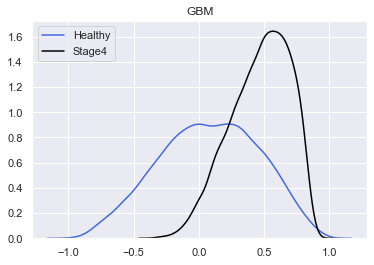

In [47]:
normal_gbm_corr_list = (ret_list(normal_gbm_corr)) 
gbm_corr_list = (ret_list(gbm_corr)) 

sns.kdeplot(normal_gbm_corr_list, label="Healthy", color = "royalblue")
sns.kdeplot(gbm_corr_list, label="Stage4", color = "black").set_title('GBM')